<a href="https://colab.research.google.com/github/frfusch21/DTS_GGU_5/blob/Hartantya-AT/quito_city_cab_ride_duration_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Get Data** Ref 1

In [232]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [233]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [234]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, ElasticNet, Lasso

from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# **Read Data** Ref 1

In [235]:
#uio = pd.read_csv('/content/drive/MyDrive/Belajar/all-data_clean.csv', header=0, sep=',', encoding="Latin1")
uio = pd.read_csv('/content/drive/MyDrive/Belajar/uio_clean.csv', header=0, sep=',', encoding="Latin1")
uio.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.503922,-0.232824,-78.549447,-0.361363,N,2025,24228,346
1,2,Quito,2016-09-18 04:03:20,2016-09-18 04:26:30,-78.440306,0.006789,-78.490786,-0.104836,N,1390,16680,456
2,3,Quito,2016-09-16 06:29:36,2016-09-18 06:41:33,-78.469551,-0.143636,-78.470277,-0.131083,N,130317,1987,290
3,4,Quito,2016-09-18 05:57:47,2016-09-18 06:30:00,-78.558076,-0.278241,-78.430220,-0.201934,N,1933,25146,302
4,5,Quito,2016-09-18 07:58:42,2016-09-18 08:14:29,-78.521818,-0.208480,-78.504558,-0.222462,N,948,4625,314


Out of all the 4 datasets the data in file uio_clean.csv is for the Quito city. The data also has date-time information for pickup and drop off. These need to be converted to python date time format

In [236]:
uio['pickup_datetime'] = pd.to_datetime(uio['pickup_datetime'], format='%Y/%m/%d %H:%M:%S')
uio['dropoff_datetime'] = pd.to_datetime(uio['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

#checked a sample of file in notepad also to verify the datetime format. 

In [237]:
print(uio['pickup_datetime'].dt.time.max()) #There seems to be some data issue with this file as the pickup times are only between 01:00:01hours and 12:59:59 hours
print(uio['pickup_datetime'].dt.time.min())

12:59:59
01:00:01


In [238]:
uio.info()
#The datetime values are successfully converted

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32366 entries, 0 to 32365
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  32366 non-null  int64         
 1   vendor_id           32366 non-null  object        
 2   pickup_datetime     32366 non-null  datetime64[ns]
 3   dropoff_datetime    32366 non-null  datetime64[ns]
 4   pickup_longitude    32366 non-null  float64       
 5   pickup_latitude     32366 non-null  float64       
 6   dropoff_longitude   32366 non-null  float64       
 7   dropoff_latitude    32366 non-null  float64       
 8   store_and_fwd_flag  32366 non-null  object        
 9   trip_duration       32366 non-null  int64         
 10  dist_meters         32366 non-null  int64         
 11  wait_sec            32366 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(4), object(2)
memory usage: 3.0+ MB


In [239]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
count,32366.000000,32366.000000,32366.000000,32366.000000,32366.000000,3.236600e+04,3.236600e+04,3.236600e+04
mean,16183.500000,-78.492371,-0.189042,-78.492901,-0.191341,4.138239e+04,7.302745e+04,2.204058e+07
std,9343.403743,0.043108,0.076153,0.044783,0.085623,5.842226e+05,1.193671e+07,7.311736e+08
min,1.000000,-80.681697,-3.454279,-80.681721,-3.574739,-3.887110e+05,1.100000e+01,0.000000e+00
25%,8092.250000,-78.505867,-0.218344,-78.505734,-0.220508,5.000000e+02,2.148000e+03,1.070000e+02
50%,16183.500000,-78.490135,-0.181979,-78.490073,-0.185721,8.970000e+02,4.124000e+03,2.430000e+02
75%,24274.750000,-78.475783,-0.148715,-78.477443,-0.149867,1.710000e+03,7.475000e+03,4.990000e+02
max,32366.000000,-78.009669,0.866441,-77.710158,0.866759,7.002605e+07,2.147484e+09,9.516306e+10


**Observations from the above table:**
* no. of records = 32,366
* ID column is unique identified for each trip - this will not add any value with respect to the modeling work. So, it will need to be dropped.
* Columns that have outliers - pickup_latitude, drop_off_latitude, trip_duration, dist_meters, wait_sec. Their max values are unreasonably high eg. trip duration max value is ~596,523 hours, which cannot be true for any trip. These will require treatment.
* Minimum trip duration is negative, which is not possible in reality
* Minimum dist_meters is ~1.1m, which again is not any meaningful trip

**Initial Data Exploration**

In [240]:
uio['vendor_id'].unique()

array(['Quito', 'Quito Cabify Lite', 'Quito Cabify Executive',
       'Quito UberX'], dtype=object)

In [241]:
uio['store_and_fwd_flag'].unique() #store and forward flag has only one value - so it's not useful for modeling purpose

array(['N'], dtype=object)

In [242]:
np.percentile(uio['trip_duration'], np.arange(0,101))

array([-3.8871100e+05,  2.3000000e+01,  3.9000000e+01,  5.8000000e+01,
        8.3600000e+01,  1.1100000e+02,  1.4190000e+02,  1.7255000e+02,
        1.9900000e+02,  2.2600000e+02,  2.4900000e+02,  2.7100000e+02,
        2.9000000e+02,  3.1200000e+02,  3.3100000e+02,  3.4675000e+02,
        3.6300000e+02,  3.7900000e+02,  3.9400000e+02,  4.1000000e+02,
        4.2700000e+02,  4.4200000e+02,  4.5600000e+02,  4.7200000e+02,
        4.8500000e+02,  5.0000000e+02,  5.1400000e+02,  5.2800000e+02,
        5.4200000e+02,  5.5600000e+02,  5.6900000e+02,  5.8500000e+02,
        5.9800000e+02,  6.1200000e+02,  6.2600000e+02,  6.4100000e+02,
        6.5700000e+02,  6.7300000e+02,  6.8800000e+02,  7.0400000e+02,
        7.1900000e+02,  7.3600000e+02,  7.5300000e+02,  7.7000000e+02,
        7.8600000e+02,  8.0525000e+02,  8.2300000e+02,  8.4000000e+02,
        8.5800000e+02,  8.7800000e+02,  8.9700000e+02,  9.1800000e+02,
        9.3600000e+02,  9.5800000e+02,  9.8110000e+02,  1.0040000e+03,
      

In [243]:
np.percentile(uio['pickup_latitude'], np.arange(0,101))

array([-3.45427926, -0.3279676 , -0.31457845, -0.30565066, -0.30047232,
       -0.29759637, -0.29122506, -0.28679532, -0.28208819, -0.27894855,
       -0.27561156, -0.27143656, -0.26823403, -0.26390717, -0.26023462,
       -0.25635074, -0.25299127, -0.25076124, -0.24805001, -0.24446868,
       -0.24132789, -0.2375631 , -0.23156556, -0.22497822, -0.22100434,
       -0.21834402, -0.2157231 , -0.21345674, -0.21155566, -0.20979412,
       -0.20801499, -0.20662379, -0.20521648, -0.20389533, -0.20248989,
       -0.2012631 , -0.19993601, -0.19863674, -0.19731877, -0.19621258,
       -0.1949322 , -0.19362547, -0.19241569, -0.19092075, -0.1893911 ,
       -0.18831635, -0.18688197, -0.18544805, -0.18405203, -0.18284984,
       -0.18197948, -0.18118765, -0.18056326, -0.18032262, -0.17890435,
       -0.17724511, -0.17685307, -0.1760617 , -0.17482229, -0.17261259,
       -0.1707287 , -0.16895395, -0.16654265, -0.16439234, -0.16376827,
       -0.16304404, -0.16261359, -0.16220723, -0.16065614, -0.15

In [244]:
#uio = uio[(uio['dropoff_latitude'] >= -0.32628809) & (uio['dropoff_latitude'] <= -0.07806344)]   #remove the outliers from dropoff latitude
#uio.shape

In [245]:
#uio = uio[(uio['pickup_latitude'] >= -0.32628809) & (uio['pickup_latitude'] <= -0.07806344)]   #remove the outliers from pickup latitude
#uio.shape


In [246]:
np.percentile(uio['dist_meters']/1000, np.arange(90,101)) #percentile distribution of trip distance in km. Based on this the upper limit
#for ditastance is chosen as  50km

array([1.31250000e+01, 1.38911500e+01, 1.48346000e+01, 1.59650000e+01,
       1.72823000e+01, 1.87310000e+01, 2.11728000e+01, 2.44233500e+01,
       2.94845000e+01, 4.03255000e+01, 2.14748365e+06])

In [247]:
uio['dist_meters'] = uio['dist_meters']/1000
uio = uio[uio['dist_meters'] <= 50]  
uio.shape

(32167, 12)

In [248]:
np.percentile(uio['trip_duration']/60, np.arange(0,101))

array([-6.47851667e+03,  3.83333333e-01,  6.50000000e-01,  9.66666667e-01,
        1.38333333e+00,  1.83333333e+00,  2.35000000e+00,  2.85000000e+00,
        3.30000000e+00,  3.74900000e+00,  4.13333333e+00,  4.50000000e+00,
        4.81666667e+00,  5.16666667e+00,  5.48333333e+00,  5.75000000e+00,
        6.01666667e+00,  6.28333333e+00,  6.53333333e+00,  6.80000000e+00,
        7.08333333e+00,  7.33333333e+00,  7.56666667e+00,  7.83333333e+00,
        8.06666667e+00,  8.30000000e+00,  8.53333333e+00,  8.76666667e+00,
        9.00000000e+00,  9.21666667e+00,  9.45000000e+00,  9.70000000e+00,
        9.93333333e+00,  1.01666667e+01,  1.04000000e+01,  1.06333333e+01,
        1.09000000e+01,  1.11570000e+01,  1.14000000e+01,  1.16833333e+01,
        1.19333333e+01,  1.22000000e+01,  1.24833333e+01,  1.27500000e+01,
        1.30333333e+01,  1.33333333e+01,  1.36333333e+01,  1.39166667e+01,
        1.42166667e+01,  1.45333333e+01,  1.48333333e+01,  1.52000000e+01,
        1.55333333e+01,  

In [249]:
uio['trip_duration'] =  uio['trip_duration']/60
uio.shape

(32167, 12)

In [250]:
uio = uio[(uio['trip_duration'] >= 0.5) & (uio['trip_duration'] <=350. )] #trip duration must be between 1 min and 350 minutes
uio.shape

(29616, 12)

In [251]:
np.percentile(uio['trip_duration'], np.arange(0,101))   #veriy the values of trip duration in minutes

array([  0.5       ,   0.7525    ,   1.08333333,   1.48333333,
         1.9       ,   2.4       ,   2.85      ,   3.26666667,
         3.66666667,   4.05      ,   4.4       ,   4.7       ,
         5.01666667,   5.31666667,   5.58333333,   5.81666667,
         6.08333333,   6.31666667,   6.55      ,   6.8       ,
         7.05      ,   7.28333333,   7.5       ,   7.73333333,
         7.96666667,   8.16666667,   8.38333333,   8.61666667,
         8.81666667,   9.03333333,   9.25      ,   9.45      ,
         9.68333333,   9.9       ,  10.11666667,  10.31666667,
        10.55      ,  10.78333333,  11.01666667,  11.25      ,
        11.48333333,  11.73333333,  11.95      ,  12.21666667,
        12.46666667,  12.73333333,  12.98333333,  13.25      ,
        13.53333333,  13.81666667,  14.06666667,  14.35      ,
        14.65      ,  14.93333333,  15.26666667,  15.56666667,
        15.86666667,  16.21666667,  16.55      ,  16.91666667,
        17.23333333,  17.58333333,  17.95      ,  18.31

In [252]:
uio['wait_sec'] = uio['wait_sec']/60
np.percentile(uio['wait_sec'], np.arange(0,101))  #distrubution of waiting time in minutes. 
#Based on this we will drop any records with more than 100 munutes of waiting tmie

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([0.00000000e+00, 5.00000000e-02, 1.50000000e-01, 2.50000000e-01,
       3.33333333e-01, 4.16666667e-01, 5.00000000e-01, 5.66666667e-01,
       6.50000000e-01, 7.33333333e-01, 8.00000000e-01, 8.83333333e-01,
       9.50000000e-01, 1.01666667e+00, 1.08333333e+00, 1.16666667e+00,
       1.21666667e+00, 1.30000000e+00, 1.35000000e+00, 1.43333333e+00,
       1.50000000e+00, 1.56666667e+00, 1.63333333e+00, 1.70000000e+00,
       1.76666667e+00, 1.85000000e+00, 1.91666667e+00, 2.00000000e+00,
       2.06666667e+00, 2.13916667e+00, 2.21666667e+00, 2.30000000e+00,
       2.38333333e+00, 2.45000000e+00, 2.53333333e+00, 2.60000000e+00,
       2.70000000e+00, 2.78333333e+00, 2.86666667e+00, 2.96666667e+00,
       3.05000000e+00, 3.13333333e+00, 3.23333333e+00, 3.31666667e+00,
       3.41666667e+00, 3.51666667e+00, 3.61666667e+00, 3.71666667e+00,
       3.81666667e+00, 3.91666667e+00, 4.03333333e+00, 4.13333333e+00,
       4.25000000e+00, 4.36666667e+00, 4.48333333e+00, 4.58333333e+00,
      

In [253]:
uio = uio[uio['wait_sec'] <= 100]
uio.shape

(29126, 12)

In [254]:
uio[uio['trip_duration'] <= uio['wait_sec']].count() #Trip duration should not be less than waiting time

id                    364
vendor_id             364
pickup_datetime       364
dropoff_datetime      364
pickup_longitude      364
pickup_latitude       364
dropoff_longitude     364
dropoff_latitude      364
store_and_fwd_flag    364
trip_duration         364
dist_meters           364
wait_sec              364
dtype: int64

In [255]:
uio =uio[uio['trip_duration'] > uio['wait_sec']]
uio.shape

(28762, 12)

In [256]:
uio[uio['trip_duration'] <= uio['wait_sec']].count()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dist_meters           0
wait_sec              0
dtype: int64

In [257]:
np.percentile(uio['trip_duration']- (uio['dropoff_datetime'] - uio['pickup_datetime']).dt.seconds/60, np.arange(0,101))
# There are some records with more than 2 minutes difference - these will need to be removed

array([-7.20000000e+02, -7.20000000e+02, -7.19983333e+02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.66666667e-02,  

In [258]:
uio = uio[np.abs(uio['trip_duration']- (uio['dropoff_datetime'] - uio['pickup_datetime']).dt.seconds/60) <= 2]
uio.shape

(28023, 12)

In [259]:
np.percentile((uio['trip_duration']- (uio['dropoff_datetime'] - uio['pickup_datetime']).dt.seconds/60), np.arange(0,101)) 
#verify the distribution of difference between trip duration and drop offf - pickup date times

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666

In [260]:
np.percentile(uio['pickup_longitude'], np.arange(0,101))

array([-79.93323685, -78.55964227, -78.55590929, -78.55242995,
       -78.54914639, -78.54520545, -78.54226593, -78.53880551,
       -78.53600767, -78.53335881, -78.53082638, -78.52838504,
       -78.526218  , -78.52351613, -78.52182069, -78.52021944,
       -78.51767156, -78.51569069, -78.51345563, -78.51161226,
       -78.51016367, -78.50896175, -78.50781917, -78.50704159,
       -78.50626295, -78.50554078, -78.50502637, -78.50486781,
       -78.50477555, -78.50422081, -78.50351316, -78.50288235,
       -78.50212298, -78.50118471, -78.50032972, -78.49968589,
       -78.49906738, -78.49860028, -78.49797287, -78.49739164,
       -78.49674836, -78.49608356, -78.49535237, -78.49463693,
       -78.49395087, -78.49330797, -78.4927187 , -78.49190544,
       -78.49118344, -78.49053662, -78.489876  , -78.48909592,
       -78.48835991, -78.48771286, -78.48716884, -78.48651641,
       -78.48589748, -78.4854635 , -78.48483314, -78.48424594,
       -78.48366673, -78.48312644, -78.48284704, -78.48

In [261]:
np.percentile(uio['dropoff_longitude'], np.arange(0,101))

array([-79.93313615, -78.56032235, -78.55705318, -78.55364776,
       -78.55061582, -78.54735762, -78.54407368, -78.5415506 ,
       -78.53884966, -78.53621876, -78.53342235, -78.53064072,
       -78.52781501, -78.52464189, -78.52225737, -78.52075394,
       -78.51863765, -78.51626206, -78.51409741, -78.51213259,
       -78.51054583, -78.50923132, -78.50795473, -78.5068725 ,
       -78.50585728, -78.50490671, -78.50429134, -78.50356248,
       -78.50294786, -78.50201937, -78.50120531, -78.50045902,
       -78.49977047, -78.49911343, -78.49853329, -78.49792252,
       -78.4974053 , -78.49682316, -78.4962022 , -78.49557012,
       -78.49507066, -78.49451969, -78.49397822, -78.49351928,
       -78.49300884, -78.49245072, -78.49189851, -78.49135692,
       -78.49092447, -78.49044051, -78.48987018, -78.48930063,
       -78.48872425, -78.48828155, -78.48789405, -78.48751622,
       -78.48710046, -78.48652221, -78.48595776, -78.48556485,
       -78.48511922, -78.48467357, -78.48422502, -78.48

In [262]:
uio.isna().sum()  #check if any NaN / nulls present

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dist_meters           0
wait_sec              0
dtype: int64

#**Data Clean-up** Ref 1

In [263]:
#In the absence of any information about how data is captured for pickup and drop off datetime and trip duration, 
#we can't make any assumption regarding which one is more accurate. So, dropping records where the time difference 
#is more than 2 minute. We are using 2 minutes here based on the percentile distribution shown in previous section 
#for this metric

In [264]:
uio.shape

(28023, 12)

In [265]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
count,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000
mean,16204.706420,-78.491650,-0.188046,-78.492094,-0.189666,20.681937,5.630726,6.406819
std,9331.393756,0.033034,0.065007,0.033457,0.066221,25.648180,5.576272,9.020875
min,1.000000,-79.933237,-2.875814,-79.933136,-2.875482,0.500000,0.020000,0.000000
25%,8171.500000,-78.505541,-0.216703,-78.504907,-0.218701,8.183333,2.247000,1.783333
50%,16211.000000,-78.489876,-0.181872,-78.489870,-0.185550,13.900000,4.070000,3.866667
75%,24295.500000,-78.475472,-0.149750,-78.477444,-0.151312,23.600000,7.072000,7.433333
max,32366.000000,-78.132979,0.866441,-78.133230,0.866759,349.683333,49.581000,99.933333


**Data Visualization**

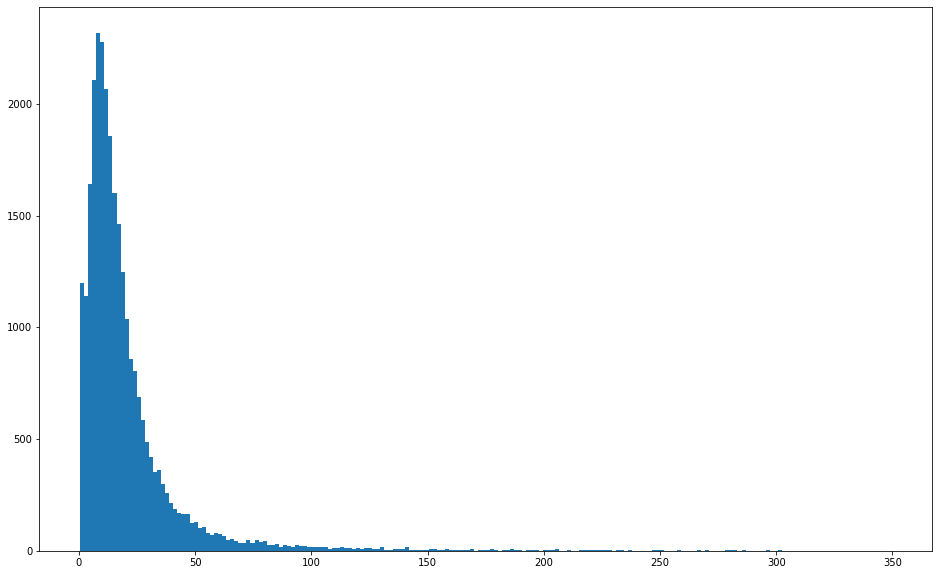

In [266]:
plt.hist(uio['trip_duration'].values, bins=200)
plt.show()

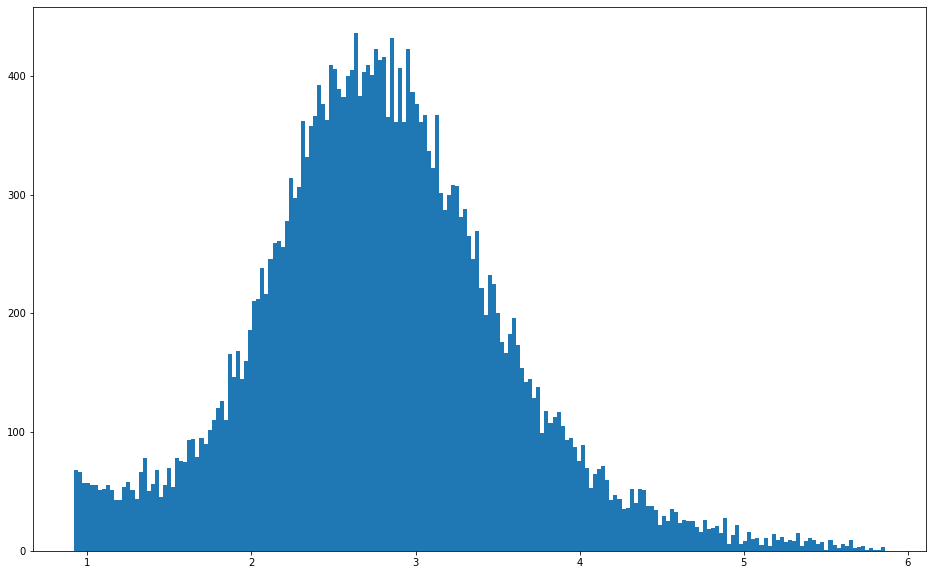

In [267]:
plt.hist(np.log1p(uio['trip_duration'].values + 1), bins=200)
plt.show()

In [268]:
vendor_freq = uio.groupby(['vendor_id'])['id'].count().reset_index()
vendor_freq

,vendor_id,id
0,Quito,27631
1,Quito Cabify Executive,60
2,Quito Cabify Lite,330
3,Quito UberX,2


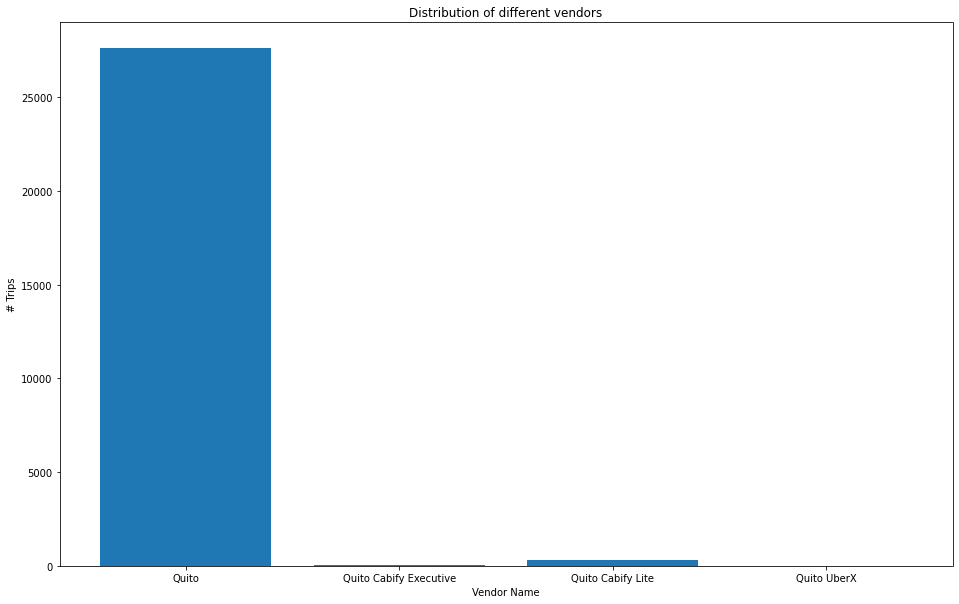

In [269]:
plt.bar(x=vendor_freq['vendor_id'], height=vendor_freq['id'])
plt.title("Distribution of different vendors")
plt.xlabel("Vendor Name")
plt.ylabel("# Trips")
plt.show()

# **Feature Engineering** Ref 1

In [270]:
def ride_length_group(distance):
    distance = distance 
    if distance <= 5 : grp = 1
    elif distance <= 10 : grp = 2
    elif distance <=15 : grp = 3
    elif distance <=20 : grp = 4
    elif distance <=25 : grp = 5
    elif distance <=30 : grp = 6
    elif distance <=35 : grp= 7
    elif distance <=40: grp= 8
    elif distance <=45: grp= 9
    else : grp=10
    return grp

def minute_group(minute):
    if minute <= 15 : grp = 1
    elif minute <= 30 : grp = 2
    elif minute <=45 : grp = 3
    else : grp=4
    return grp

In [271]:
uio['ride_length_grp'] = uio['dist_meters'].apply(ride_length_group)

In [272]:
uio['ride_month'] = uio['pickup_datetime'].dt.month
uio['ride_year'] = uio['pickup_datetime'].dt.year
uio['ride_day'] = uio['pickup_datetime'].dt.day
uio['ride_hour'] = uio['pickup_datetime'].dt.hour
uio['ride_minute'] = uio['pickup_datetime'].dt.minute
uio['day_of_week'] = uio['pickup_datetime'].dt.dayofweek

uio['season'] = uio['ride_month'].apply(lambda x: 1 if x >= 6 and x <= 9 else 0) #Quito has two seasons only as per https://en.wikipedia.org/wiki/Climate_of_Ecuador
# Since Quito lies on equator, there is not much difference in daylight duration across the year

uio['vendor_flg'] = uio['vendor_id'].apply(lambda x: 1 if x.lower()=='quito' else 0)
uio['minute_grp'] = uio['ride_minute'].apply(minute_group)

uio['diff_longitude'] = np.round(uio['dropoff_longitude'] - uio['pickup_longitude'], decimals=4)
uio['diff_latitude'] = np.round(uio['dropoff_latitude'] - uio['pickup_latitude'], decimals=4)
uio.head()


# https://www.officeholidays.com/countries/ecuador/2017.php - holidays list of Ecuador
holidays = ['2016-01-01', '2016-02-08', '2016-02-09', '2016-03-25', '2016-03-27', 
            '2016-05-01', '2016-05-27', '2016-07-24', '2016-08-10', '2016-10-09', 
            '2016-11-02', '2016-11-03', '2016-12-06', '2016-12-25', 
            '2017-01-01', '2017-02-27', '2017-02-28', '2017-04-14', '2017-04-16', 
            '2017-05-01', '2017-05-24', '2017-07-24', '2017-08-10', '2017-10-09', 
            '2017-11-02', '2017-11-03', '2017-12-06', '2017-12-25']
holidays = pd.to_datetime(holidays)
# was the day a public holiday?


uio['holiday'] = 1*(pd.to_datetime(uio['pickup_datetime'].dt.date).isin(holidays))

uio['pickup_latitude'] = np.round(uio['pickup_latitude'], decimals =4)
uio['dropoff_latitude'] = np.round(uio['dropoff_latitude'], decimals =4)
uio['pickup_longitude'] = np.round(uio['pickup_longitude'], decimals =4)
uio['dropoff_longitude'] = np.round(uio['dropoff_longitude'], decimals =4)

uio['trip_duration_log'] = np.log1p(uio['trip_duration'] + 1)
#wait_sec and dropoff_time should not be used for prediction as that can cause leakage

uio['average_speed'] = uio['dist_meters'] / (uio['trip_duration']/60)    # in km per hour

uio.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,ride_minute,day_of_week,season,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.5039,-0.2328,-78.5494,-0.3614,N,33.750000,...,32,5,1,1,3,-0.0455,-0.1285,0,3.576550,43.072000
1,2,Quito,2016-09-18 04:03:20,2016-09-18 04:26:30,-78.4403,0.0068,-78.4908,-0.1048,N,23.166667,...,3,6,1,1,1,-0.0505,-0.1116,0,3.225520,43.200000
3,4,Quito,2016-09-18 05:57:47,2016-09-18 06:30:00,-78.5581,-0.2782,-78.4302,-0.2019,N,32.216667,...,57,6,1,1,4,0.1279,0.0763,0,3.532713,46.831661
4,5,Quito,2016-09-18 07:58:42,2016-09-18 08:14:29,-78.5218,-0.2085,-78.5046,-0.2225,N,15.800000,...,58,6,1,1,4,0.0173,-0.0140,0,2.879198,17.563291
5,6,Quito,2016-08-27 04:19:02,2016-08-27 04:44:12,-78.5092,-0.1948,-78.5188,-0.2288,N,25.166667,...,19,5,1,1,2,-0.0096,-0.0340,0,3.301991,13.875497


# **Feature Engineering Lanjutan**  Ref 1 - SKIP

In [82]:
uio['holiday'].sum()

601

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


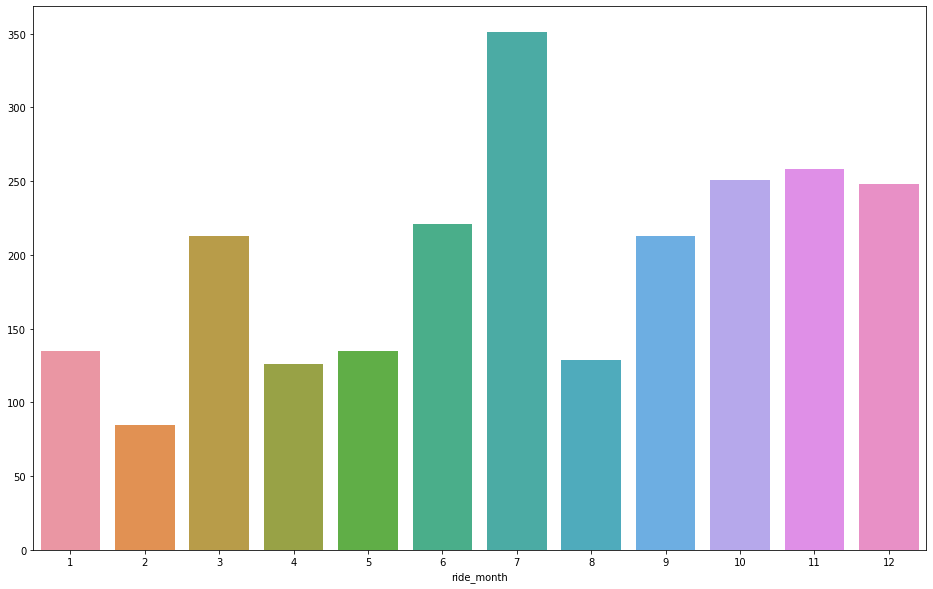

In [596]:
x = uio.groupby(['ride_month'])['id'].count() # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
sns.barplot(x.index, x.values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


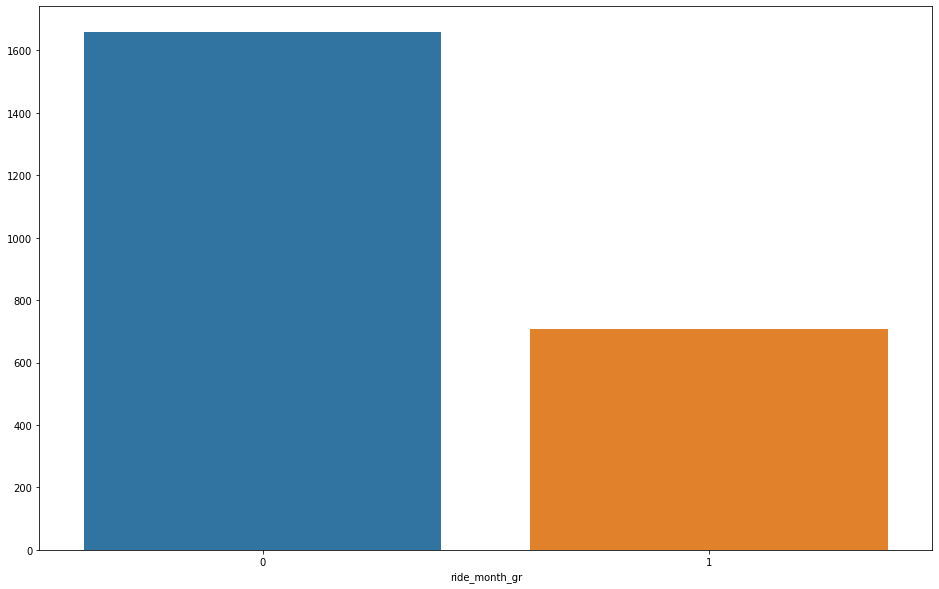

In [597]:
uio['ride_month_gr'] = uio['ride_month'].apply(lambda x: 1 if x in (1,6,7) else 0)
x = uio.groupby(['ride_month_gr'])['id'].count() # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
sns.barplot(x.index, x.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


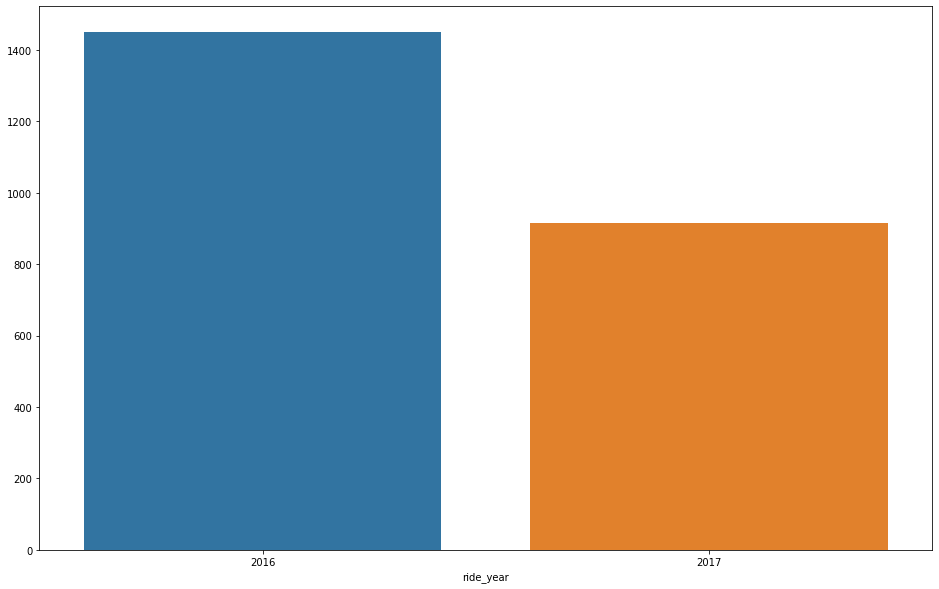

In [598]:
x = uio.groupby(['ride_year'])['id'].count() # There are more rides in 2017
sns.barplot(x.index, x.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


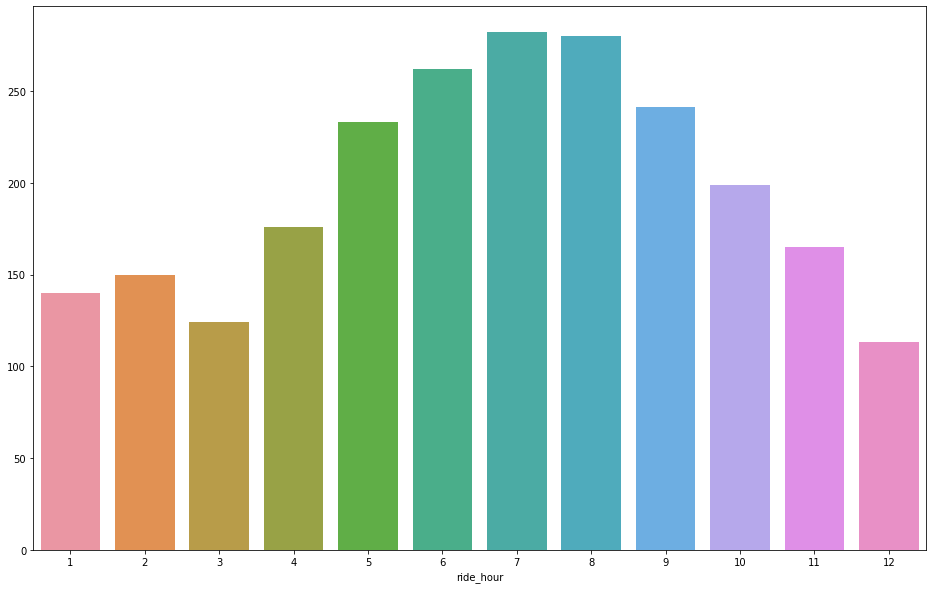

In [599]:
x = uio.groupby(['ride_hour'])['id'].count() # There is some seasonality based on the time of the day
sns.barplot(x.index, x.values)
plt.show()

In [600]:
uio['ride_hour_gr'] = uio['ride_hour'].apply(lambda x: 1 if x in (6,7,8,9) else 0)  #flag set to 1 if rides are booked in these hours

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


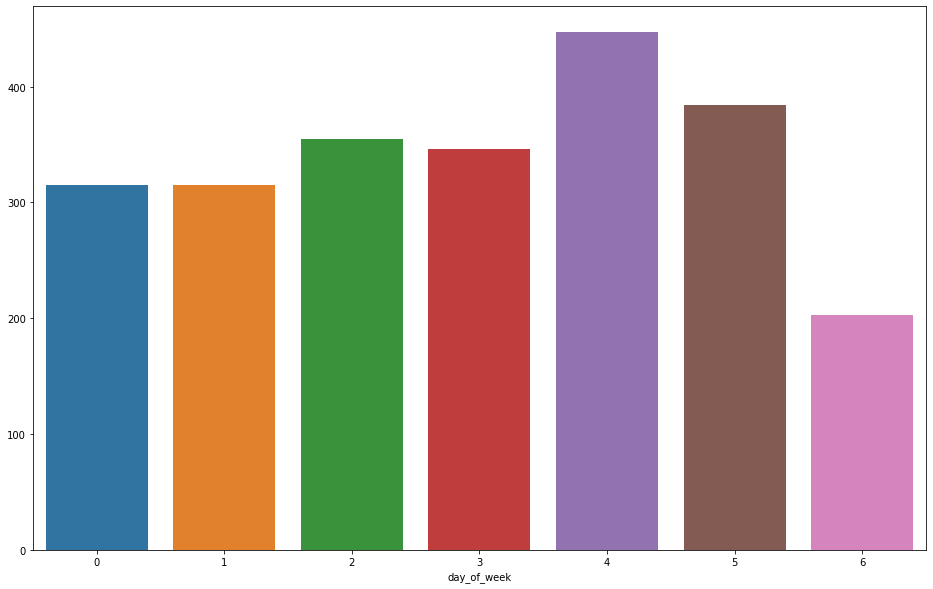

In [601]:
x = uio.groupby(['day_of_week'])['id'].count() # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
sns.barplot(x.index, x.values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


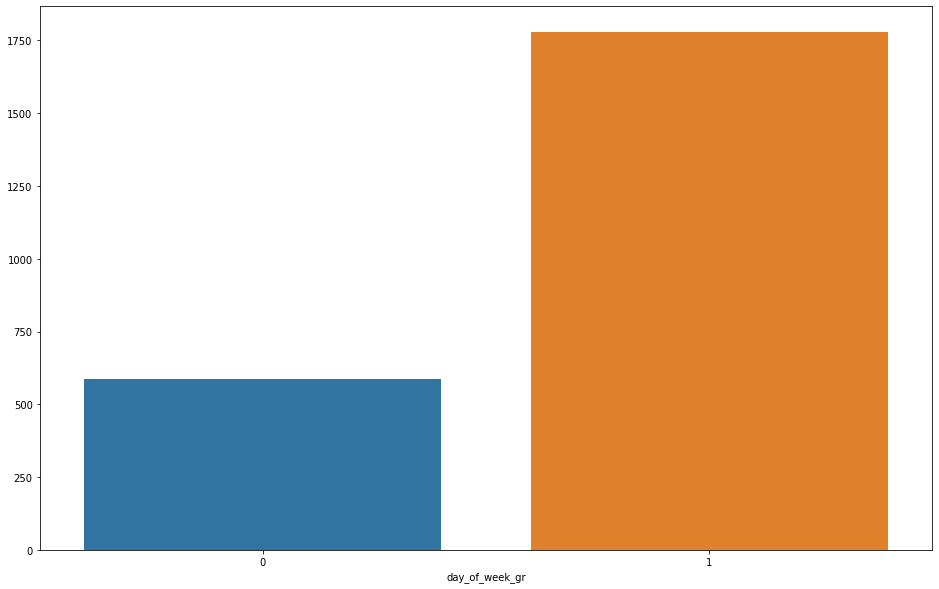

In [602]:
uio['day_of_week_gr'] = uio['day_of_week'].apply(lambda x: 1 if x in (0,1,2,3,4) else 0) # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
x = uio.groupby(['day_of_week_gr'])['id'].count()
sns.barplot(x.index, x.values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

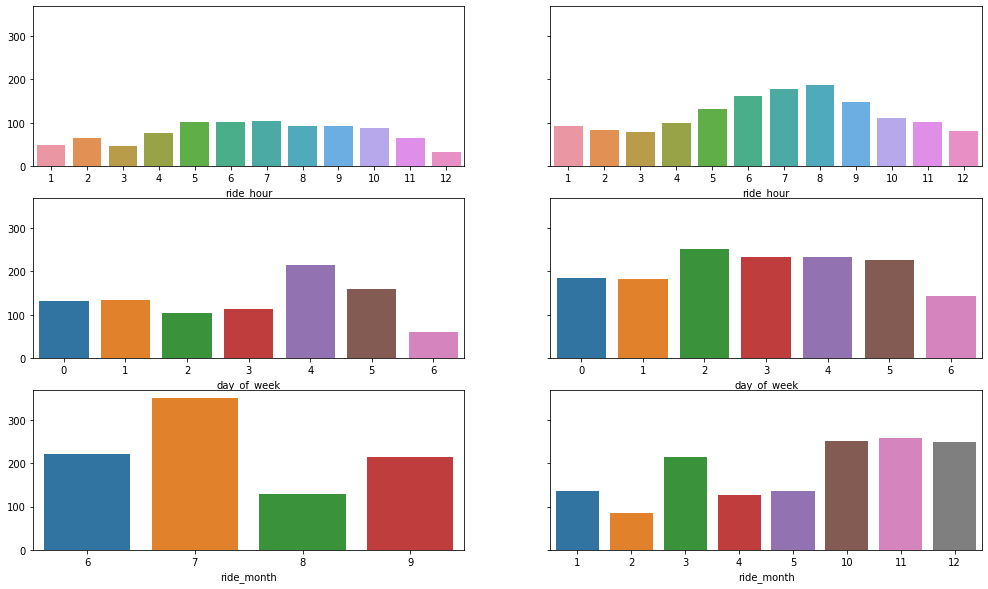

In [605]:
f, axes = plt.subplots(3,2,figsize=(17,10), sharey=True)

dat = uio[uio['season']==1].groupby(['ride_hour'])['id'].count()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[0,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['ride_hour'])['id'].count()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[0,1])
#fig2.set_ylim = 3000

dat = uio[uio['season']==1].groupby(['day_of_week'])['id'].count()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[1,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['day_of_week'])['id'].count()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[1,1])

dat = uio[uio['season']==1].groupby(['ride_month'])['id'].count()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[2,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['ride_month'])['id'].count()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[2,1])

In [608]:
np.percentile(uio['average_speed'], np.arange(0,101))

array([-1.49824441e+07,  1.59982970e-01,  3.66549700e-01,  6.57396808e-01,
        9.70896645e-01,  1.35620553e+00,  1.73935847e+00,  2.12614446e+00,
        2.37094054e+00,  2.83172576e+00,  3.19863278e+00,  3.60308998e+00,
        4.00690258e+00,  4.39872673e+00,  4.65792513e+00,  5.19249709e+00,
        5.66343677e+00,  6.24975376e+00,  6.80291877e+00,  7.07392553e+00,
        7.43958004e+00,  7.81177189e+00,  8.17633618e+00,  8.52625374e+00,
        8.83292955e+00,  9.17708895e+00,  9.52427078e+00,  9.81421275e+00,
        1.00735523e+01,  1.04024736e+01,  1.06997865e+01,  1.09834658e+01,
        1.12568251e+01,  1.14544335e+01,  1.17286755e+01,  1.19285484e+01,
        1.21354848e+01,  1.23855355e+01,  1.26347660e+01,  1.28944291e+01,
        1.31788396e+01,  1.34197760e+01,  1.37017524e+01,  1.40266428e+01,
        1.42772315e+01,  1.45428420e+01,  1.47696333e+01,  1.49459655e+01,
        1.51252037e+01,  1.53294108e+01,  1.56303797e+01,  1.58292267e+01,
        1.60525652e+01,  

In [609]:
uio = uio[uio['average_speed'] <= 150]
uio.shape

(2363, 27)

In [610]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing
count,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2.363000e+03,2363.000000,2363.000000,2363.000000,...,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2.363000e+03,2363.000000,2363.000000,2363.000000,2363.000000
mean,1527.969953,-74.098161,4.670515,-74.099389,4.669074,31.706785,-1.810649e+03,9.131979,1.967837,7.265764,...,2.403724,-0.001230,-0.001443,0.033009,3.029008,-8.098780e+03,0.298773,0.450698,0.752010,-4.873488
std,873.990500,0.138359,0.090209,0.139042,0.090593,38.192407,6.246295e+04,13.187295,1.354510,3.296850,...,1.110882,0.032811,0.043478,0.178698,1.023692,3.200303e+05,0.457817,0.497669,0.431937,105.336988
min,1.000000,-76.534400,3.393700,-76.542500,3.394600,0.500000,-2.147484e+06,0.000000,1.000000,1.000000,...,1.000000,-0.205400,-0.205700,0.000000,0.916291,-1.498244e+07,0.000000,0.000000,0.000000,-179.614989
25%,767.500000,-74.123300,4.629750,-74.119850,4.628100,8.766667,1.880000e+00,1.416667,1.000000,5.000000,...,1.000000,-0.013000,-0.012850,0.000000,2.376454,9.175083e+00,0.000000,0.000000,1.000000,-100.130339
50%,1541.000000,-74.085800,4.685200,-74.088700,4.677600,20.050000,5.139000e+00,4.400000,2.000000,7.000000,...,2.000000,0.000000,-0.000100,0.000000,3.093313,1.560784e+01,0.000000,0.000000,1.000000,0.000000
75%,2268.000000,-74.055050,4.714450,-74.058700,4.718300,39.491667,9.691000e+00,10.858333,2.000000,10.000000,...,3.000000,0.011100,0.012100,0.000000,3.725493,2.225655e+01,1.000000,1.000000,1.000000,86.655248
max,3062.000000,-73.831700,5.023900,-73.823800,5.024700,338.783333,4.968900e+01,98.433333,10.000000,12.000000,...,4.000000,0.149100,0.217300,1.000000,5.831247,1.443214e+02,1.000000,1.000000,1.000000,180.000000


In [611]:
dat = uio
#dat = pd.concat([uio, ride_year, ride_month, ride_day, ride_hour, minute_grp], axis=1)
#dat.head()

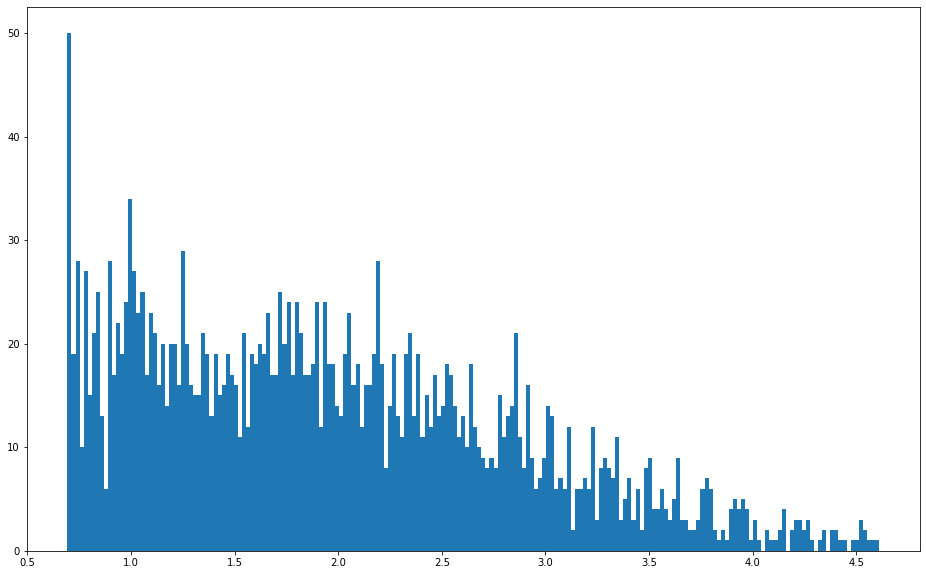

In [612]:
y = np.log1p(dat['wait_sec'] + 1)
x = dat.drop(['wait_sec'], axis = 1)
plt.hist(y, bins=200)
plt.show()

# **Feature Engineering Bearing** Ref 1
*horizontal angle between direction of an object and another object*

In [273]:
import math
def bearing_array(lat1, lng1, lat2, lng2):
    """bearing:
    horizontal angle between direction of an object and another object"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [274]:
uio.loc[:,'bearing'] = bearing_array(uio['pickup_latitude'].values, uio['pickup_longitude'].values, 
                               uio['dropoff_latitude'].values, uio['dropoff_longitude'].values)
uio.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,day_of_week,season,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,bearing
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.5039,-0.2328,-78.5494,-0.3614,N,33.750000,...,5,1,1,3,-0.0455,-0.1285,0,3.576550,43.072000,-160.516053
1,2,Quito,2016-09-18 04:03:20,2016-09-18 04:26:30,-78.4403,0.0068,-78.4908,-0.1048,N,23.166667,...,6,1,1,1,-0.0505,-0.1116,0,3.225520,43.200000,-155.652847
3,4,Quito,2016-09-18 05:57:47,2016-09-18 06:30:00,-78.5581,-0.2782,-78.4302,-0.2019,N,32.216667,...,6,1,1,4,0.1279,0.0763,0,3.532713,46.831661,59.181455
4,5,Quito,2016-09-18 07:58:42,2016-09-18 08:14:29,-78.5218,-0.2085,-78.5046,-0.2225,N,15.800000,...,6,1,1,4,0.0173,-0.0140,0,2.879198,17.563291,129.144217
5,6,Quito,2016-08-27 04:19:02,2016-08-27 04:44:12,-78.5092,-0.1948,-78.5188,-0.2288,N,25.166667,...,5,1,1,2,-0.0096,-0.0340,0,3.301991,13.875497,-164.232937


Getting Data Ready for the Model Build: 
* Create dummies
* Drop variables that are not useful for modeling eg. store_and_forward_flag, id, vendor_id
* Variables based on which dummies were created
* Variables that will cause leakage eg. dropoff_datetime, wait_time
* Two stage model can be built where first wait time is predicted and then using wait time and other independent variables predict the trip duration

In [275]:
uio = uio.drop(columns = ['vendor_id', 'dropoff_datetime', 'store_and_fwd_flag', 'pickup_datetime' ], axis=1)
uio.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,day_of_week,season,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,bearing
0,1,-78.5039,-0.2328,-78.5494,-0.3614,33.750000,24.228,5.766667,5,9,...,5,1,1,3,-0.0455,-0.1285,0,3.576550,43.072000,-160.516053
1,2,-78.4403,0.0068,-78.4908,-0.1048,23.166667,16.680,7.600000,4,9,...,6,1,1,1,-0.0505,-0.1116,0,3.225520,43.200000,-155.652847
3,4,-78.5581,-0.2782,-78.4302,-0.2019,32.216667,25.146,5.033333,6,9,...,6,1,1,4,0.1279,0.0763,0,3.532713,46.831661,59.181455
4,5,-78.5218,-0.2085,-78.5046,-0.2225,15.800000,4.625,5.233333,1,9,...,6,1,1,4,0.0173,-0.0140,0,2.879198,17.563291,129.144217
5,6,-78.5092,-0.1948,-78.5188,-0.2288,25.166667,5.820,10.500000,2,8,...,5,1,1,2,-0.0096,-0.0340,0,3.301991,13.875497,-164.232937


In [276]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,day_of_week,season,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,bearing
count,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,...,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000
mean,16204.706420,-78.491650,-0.188046,-78.492094,-0.189666,20.681937,5.630726,6.406819,1.657960,6.541056,...,2.711630,0.385897,0.986011,2.426007,-0.000444,-0.001620,0.021447,2.795470,19.313540,-14.688721
std,9331.393756,0.033034,0.065007,0.033457,0.066221,25.648180,5.576272,9.020875,1.111103,3.371246,...,1.855022,0.486815,0.117445,1.119929,0.020698,0.037313,0.144870,0.764280,12.267398,107.965072
min,1.000000,-79.933200,-2.875800,-79.933100,-2.875500,0.500000,0.020000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,-0.185100,-0.342300,0.000000,0.916291,0.007440,-179.918615
25%,8171.500000,-78.505500,-0.216700,-78.504900,-0.218700,8.183333,2.247000,1.783333,1.000000,4.000000,...,1.000000,0.000000,1.000000,1.000000,-0.010100,-0.016600,0.000000,2.320752,12.939997,-124.124831
50%,16211.000000,-78.489900,-0.181900,-78.489900,-0.185600,13.900000,4.070000,3.866667,1.000000,7.000000,...,3.000000,0.000000,1.000000,2.000000,-0.000100,-0.000200,0.000000,2.766319,18.346407,-0.541531
75%,24295.500000,-78.475500,-0.149750,-78.477400,-0.151300,23.600000,7.072000,7.433333,2.000000,9.000000,...,4.000000,1.000000,1.000000,3.000000,0.009200,0.013500,0.000000,3.242592,24.206029,62.326466
max,32366.000000,-78.133000,0.866400,-78.133200,0.866800,349.683333,49.581000,99.933333,10.000000,12.000000,...,6.000000,1.000000,1.000000,4.000000,0.209300,0.346800,1.000000,5.862731,741.245902,180.000000


# **Clustering Coordinates** Ref 3 (most recommend)

In [277]:
from sklearn.cluster import KMeans

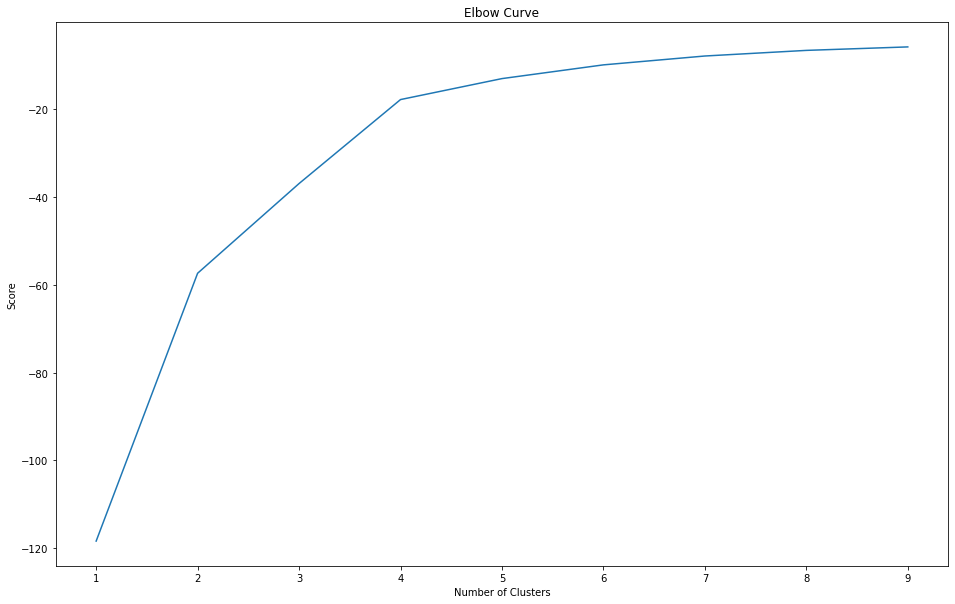

In [278]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = uio[['pickup_latitude']]
X_axis = uio[['pickup_longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [279]:
kmeans = KMeans(n_clusters = 4, init ='k-means++', max_iter=100, n_init=1, verbose=0, random_state=3425)
kmeans.fit(uio[['pickup_latitude', 'pickup_longitude']]) # Compute k-means clustering.
uio['cluster_pickup_ref3'] = kmeans.fit_predict(uio[['pickup_latitude', 'pickup_longitude']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(uio[['pickup_latitude', 'pickup_longitude']]) # Labels of each point
uio.head(10)

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,season,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,bearing,cluster_pickup_ref3
0,1,-78.5039,-0.2328,-78.5494,-0.3614,33.750000,24.228,5.766667,5,9,...,1,1,3,-0.0455,-0.1285,0,3.576550,43.072000,-160.516053,1
1,2,-78.4403,0.0068,-78.4908,-0.1048,23.166667,16.680,7.600000,4,9,...,1,1,1,-0.0505,-0.1116,0,3.225520,43.200000,-155.652847,2
3,4,-78.5581,-0.2782,-78.4302,-0.2019,32.216667,25.146,5.033333,6,9,...,1,1,4,0.1279,0.0763,0,3.532713,46.831661,59.181455,1
4,5,-78.5218,-0.2085,-78.5046,-0.2225,15.800000,4.625,5.233333,1,9,...,1,1,4,0.0173,-0.0140,0,2.879198,17.563291,129.144217,0
5,6,-78.5092,-0.1948,-78.5188,-0.2288,25.166667,5.820,10.500000,2,8,...,1,1,2,-0.0096,-0.0340,0,3.301991,13.875497,-164.232937,0
6,7,-78.4815,-0.1543,-78.5184,-0.1915,22.350000,7.593,8.500000,2,9,...,1,1,1,-0.0369,-0.0372,0,3.192532,20.383893,-135.232150,0
7,8,-78.5298,-0.2491,-78.3611,-0.1246,47.016667,46.418,5.033333,10,9,...,1,1,1,0.1687,0.1245,0,3.892160,59.236016,53.572961,1
8,9,-78.3611,-0.1246,-78.3927,-0.0894,18.333333,8.150,6.500000,2,9,...,1,1,4,-0.0317,0.0352,0,3.012262,26.672727,-41.915169,2
9,10,-78.4971,-0.2004,-78.4998,-0.2073,1.816667,0.827,0.483333,1,9,...,1,1,2,-0.0026,-0.0069,0,1.339377,27.313761,-158.629506,0
10,11,-78.4998,-0.2073,-78.5068,-0.2260,8.250000,2.549,2.150000,1,9,...,1,1,2,-0.0070,-0.0187,0,2.327278,18.538182,-159.477687,0


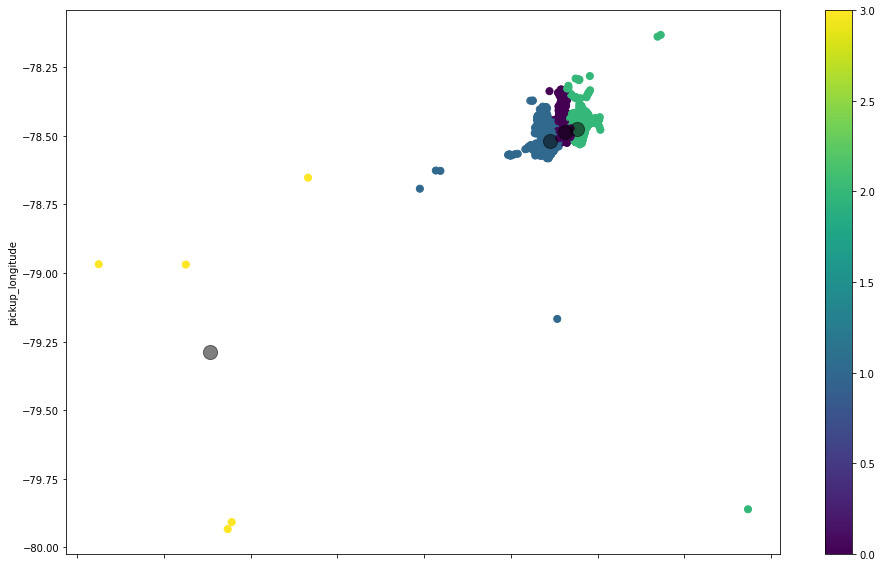

In [280]:
uio.plot.scatter(x = 'pickup_latitude', y = 'pickup_longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

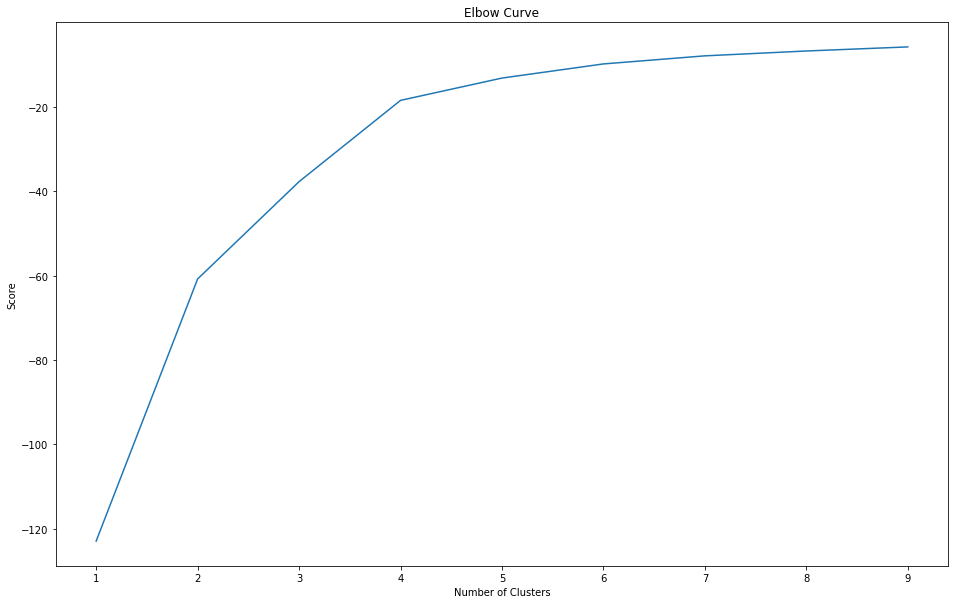

In [281]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = uio[['dropoff_latitude']]
X_axis = uio[['dropoff_longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [282]:
kmeans = KMeans(n_clusters = 4, init ='k-means++', max_iter=100, n_init=1, verbose=0, random_state=3425)
kmeans.fit(uio[['dropoff_latitude', 'dropoff_longitude']]) # Compute k-means clustering.
uio['cluster_dropoff_ref3'] = kmeans.fit_predict(uio[['dropoff_latitude', 'dropoff_longitude']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(uio[['dropoff_latitude', 'dropoff_longitude']]) # Labels of each point
uio.head(10)

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,bearing,cluster_pickup_ref3,cluster_dropoff_ref3
0,1,-78.5039,-0.2328,-78.5494,-0.3614,33.750000,24.228,5.766667,5,9,...,1,3,-0.0455,-0.1285,0,3.576550,43.072000,-160.516053,1,1
1,2,-78.4403,0.0068,-78.4908,-0.1048,23.166667,16.680,7.600000,4,9,...,1,1,-0.0505,-0.1116,0,3.225520,43.200000,-155.652847,2,2
3,4,-78.5581,-0.2782,-78.4302,-0.2019,32.216667,25.146,5.033333,6,9,...,1,4,0.1279,0.0763,0,3.532713,46.831661,59.181455,1,0
4,5,-78.5218,-0.2085,-78.5046,-0.2225,15.800000,4.625,5.233333,1,9,...,1,4,0.0173,-0.0140,0,2.879198,17.563291,129.144217,0,0
5,6,-78.5092,-0.1948,-78.5188,-0.2288,25.166667,5.820,10.500000,2,8,...,1,2,-0.0096,-0.0340,0,3.301991,13.875497,-164.232937,0,1
6,7,-78.4815,-0.1543,-78.5184,-0.1915,22.350000,7.593,8.500000,2,9,...,1,1,-0.0369,-0.0372,0,3.192532,20.383893,-135.232150,0,0
7,8,-78.5298,-0.2491,-78.3611,-0.1246,47.016667,46.418,5.033333,10,9,...,1,1,0.1687,0.1245,0,3.892160,59.236016,53.572961,1,2
8,9,-78.3611,-0.1246,-78.3927,-0.0894,18.333333,8.150,6.500000,2,9,...,1,4,-0.0317,0.0352,0,3.012262,26.672727,-41.915169,2,2
9,10,-78.4971,-0.2004,-78.4998,-0.2073,1.816667,0.827,0.483333,1,9,...,1,2,-0.0026,-0.0069,0,1.339377,27.313761,-158.629506,0,0
10,11,-78.4998,-0.2073,-78.5068,-0.2260,8.250000,2.549,2.150000,1,9,...,1,2,-0.0070,-0.0187,0,2.327278,18.538182,-159.477687,0,0


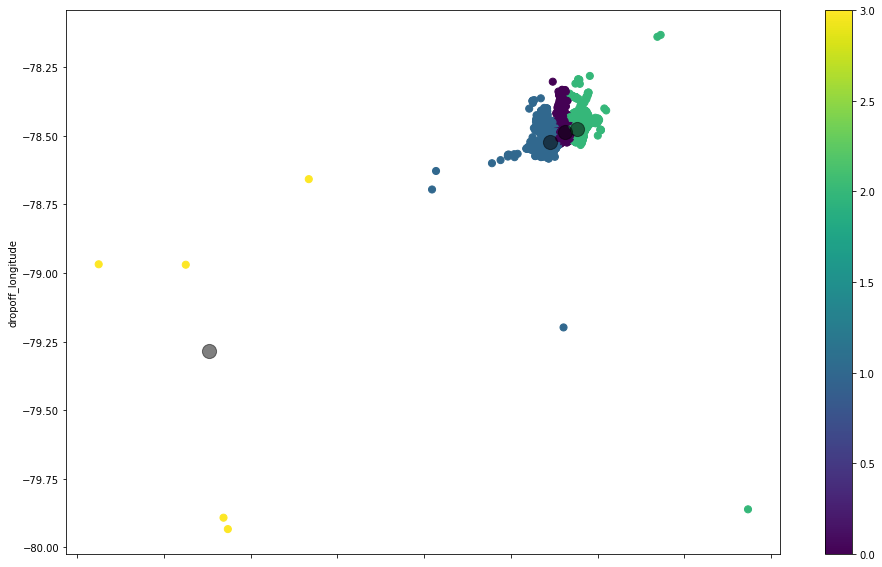

In [283]:
uio.plot.scatter(x = 'dropoff_latitude', y = 'dropoff_longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# **Clustering Coordinate** Ref 2

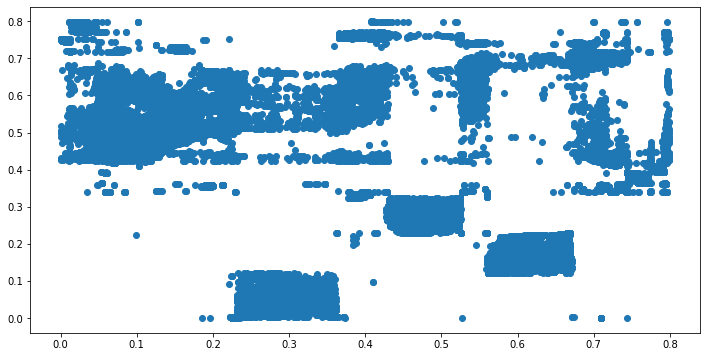

In [93]:
plt.figure(figsize=(12, 6))
plt.scatter(uio['pickup_latitude'], uio['pickup_longitude'])
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=10)

uio['cluster_ref2'] = kmeans.fit_predict(uio[['pickup_latitude', 'pickup_longitude']])

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(uio['pickup_latitude'][uio['cluster_ref2'] == 0], uio['pickup_longitude'][uio['cluster_ref2'] == 0], c='r', label='c0')
plt.scatter(uio['pickup_latitude'][uio['cluster_ref2'] == 1], uio['pickup_longitude'][uio['cluster_ref2'] == 1], c='y', label='c1')
plt.scatter(uio['pickup_latitude'][uio['cluster_ref2'] == 2], uio['pickup_longitude'][uio['cluster_ref2'] == 2], c='g', label='c2')
plt.legend()
plt.show()

# **Cluestering Coordinate**  Ref 1

In [230]:
train_X, test_X, train_Y, test_Y = train_test_split(x, y, test_size = 0.2, shuffle=True, random_state = 65).copy()

In [231]:
print("Shape of X train", train_X.shape)
print("Shape of Y train", train_Y.shape)
print("Shape of X test", test_X.shape)
print("Shape of Y test", test_Y.shape)

Shape of X train (61018, 26)
Shape of Y train (61018,)
Shape of X test (15255, 26)
Shape of Y test (15255,)


In [232]:
coordinates = np.vstack((train_X[['pickup_latitude', 'pickup_longitude']].values, train_X[['dropoff_latitude', 'dropoff_longitude']].values))

In [233]:
scaler = StandardScaler()
coordinates_std = scaler.fit_transform(coordinates)
clustering = MiniBatchKMeans(n_clusters=70, random_state=203, batch_size=10000)
model = clustering.fit(coordinates_std)

In [234]:
X_Tr = train_X.copy().reset_index().drop('index', axis=1)
Y_Tr = train_Y.copy().reset_index().drop('index', axis=1)
X_Te = test_X.copy().reset_index().drop('index', axis=1)
Y_Te = test_Y.copy().reset_index().drop('index', axis=1)

X_Tr['kms_pick_cluster'] = pd.Series(model.predict(scaler.fit_transform(X_Tr[['pickup_latitude', 'pickup_longitude']])))
X_Tr['kms_drop_cluster'] = pd.Series(model.predict(scaler.fit_transform(X_Tr[['dropoff_latitude', 'dropoff_longitude']])))
X_Te['kms_pick_cluster'] = pd.Series(model.predict(scaler.fit_transform(X_Te[['pickup_latitude', 'pickup_longitude']])))
X_Te['kms_drop_cluster'] = pd.Series(model.predict(scaler.fit_transform(X_Te[['dropoff_latitude', 'dropoff_longitude']])))

In [235]:
X_Tr.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,ride_length_grp,ride_month,ride_year,...,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing,kms_pick_cluster,kms_drop_cluster
0,29689,0.0557,0.3350,-99.1643,19.4238,13.650000,5.997,2,7,2017,...,19.0888,0,2.750471,26.360440,1,0,1,-70.293446,12,13
1,45033,0.4700,0.0857,-78.4754,-0.1644,23.466667,4.356,1,12,2016,...,-0.2500,0,3.237370,11.137500,0,1,1,-90.184251,19,50
2,30690,0.7308,0.1474,-78.6430,-1.6821,7.900000,7.209,2,7,2017,...,-1.8295,0,2.292535,54.751899,1,0,1,-91.739056,32,19
3,71862,0.1176,0.2620,-99.2700,19.3249,3.550000,0.783,1,1,2017,...,19.0629,0,1.713798,13.233803,1,1,0,-70.394328,12,13
4,52120,0.2234,0.6279,-100.5133,25.7026,6.133333,2.935,1,7,2016,...,25.0747,0,2.095971,28.711957,1,0,1,-63.805201,13,61


In [236]:
X_Te.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,ride_length_grp,ride_month,ride_year,...,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing,kms_pick_cluster,kms_drop_cluster
0,49333,0.1760,0.5677,-100.3043,25.6293,32.866667,11.005,3,2,2017,...,25.0616,0,3.551531,20.090264,0,0,0,-63.909160,13,61
1,56993,0.4143,0.7216,-76.5215,3.4645,28.266667,11.451,3,2,2017,...,2.7429,0,3.410047,24.306368,0,0,1,-86.610789,61,37
2,52742,0.3691,0.7635,-74.0485,4.7287,6.733333,2.789,1,8,2016,...,3.9652,0,2.167147,24.852475,0,0,1,-85.303586,61,34
3,948,0.5428,0.1154,-78.4883,-0.2011,23.566667,7.332,2,4,2017,...,-0.3165,0,3.241289,18.667044,0,0,1,-90.227208,32,50
4,15624,0.0545,0.3229,-99.0904,19.4479,21.016667,11.290,3,11,2016,...,19.1251,0,3.136219,32.231562,0,0,0,-70.275067,12,13


In [237]:

print(X_Tr.shape)
print(Y_Tr.shape)
print(X_Te.shape)
print(Y_Te.shape)

print(X_Tr['kms_pick_cluster'].isna().sum())
print(X_Tr['kms_drop_cluster'].isna().sum())
print(X_Te['kms_pick_cluster'].isna().sum())
print(X_Te['kms_drop_cluster'].isna().sum())

(61018, 28)
(61018, 1)
(15255, 28)
(15255, 1)
0
0
0
0


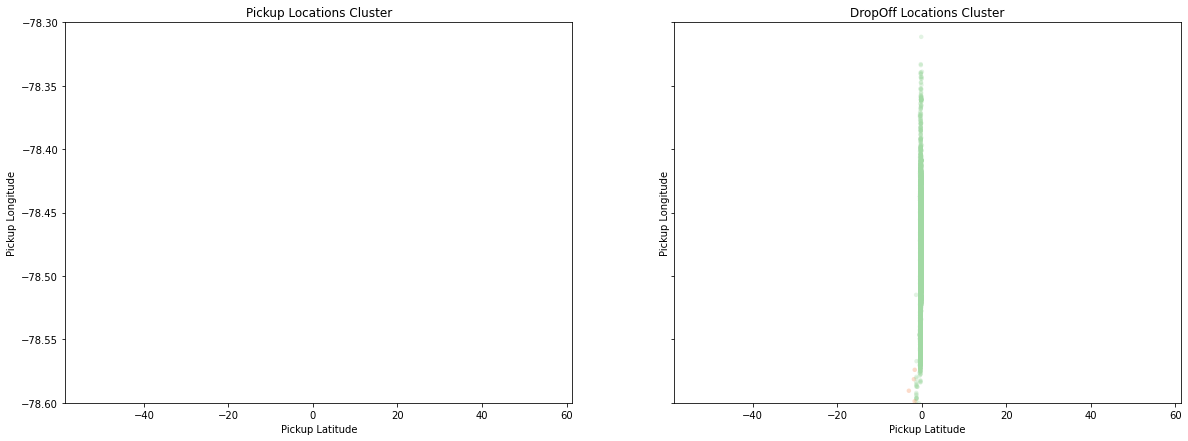

In [238]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=True, sharey=True)
axes[0].scatter(X_Tr['pickup_latitude'], X_Tr['pickup_longitude'], c=X_Tr['kms_pick_cluster'], alpha=0.3, lw = 0, s=20, cmap='Spectral')
axes[0].set_title('Pickup Locations Cluster')
axes[0].set_xlabel('Pickup Latitude')
axes[0].set_ylabel('Pickup Longitude')
axes[0].set_ylim([-78.6, -78.3])

axes[1].scatter(X_Tr['dropoff_latitude'], X_Tr['dropoff_longitude'], c=X_Tr['kms_drop_cluster'], alpha=0.3, lw = 0, s=20, cmap='Spectral')
axes[1].set_title('DropOff Locations Cluster')
axes[1].set_xlabel('Pickup Latitude')
axes[1].set_ylabel('Pickup Longitude')
plt.show()

In [239]:
X_Tr.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,ride_length_grp,ride_month,ride_year,...,diff_latitude,holiday,trip_duration_log,average_speed,ride_month_gr,ride_hour_gr,day_of_week_gr,bearing,kms_pick_cluster,kms_drop_cluster
0,29689,0.0557,0.3350,-99.1643,19.4238,13.650000,5.997,2,7,2017,...,19.0888,0,2.750471,26.360440,1,0,1,-70.293446,12,13
1,45033,0.4700,0.0857,-78.4754,-0.1644,23.466667,4.356,1,12,2016,...,-0.2500,0,3.237370,11.137500,0,1,1,-90.184251,19,50
2,30690,0.7308,0.1474,-78.6430,-1.6821,7.900000,7.209,2,7,2017,...,-1.8295,0,2.292535,54.751899,1,0,1,-91.739056,32,19
3,71862,0.1176,0.2620,-99.2700,19.3249,3.550000,0.783,1,1,2017,...,19.0629,0,1.713798,13.233803,1,1,0,-70.394328,12,13
4,52120,0.2234,0.6279,-100.5133,25.7026,6.133333,2.935,1,7,2016,...,25.0747,0,2.095971,28.711957,1,0,1,-63.805201,13,61


# **Hasil Akhir Tabel**

In [284]:
uio.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,bearing,cluster_pickup_ref3,cluster_dropoff_ref3
0,1,-78.5039,-0.2328,-78.5494,-0.3614,33.750000,24.228,5.766667,5,9,...,1,3,-0.0455,-0.1285,0,3.576550,43.072000,-160.516053,1,1
1,2,-78.4403,0.0068,-78.4908,-0.1048,23.166667,16.680,7.600000,4,9,...,1,1,-0.0505,-0.1116,0,3.225520,43.200000,-155.652847,2,2
3,4,-78.5581,-0.2782,-78.4302,-0.2019,32.216667,25.146,5.033333,6,9,...,1,4,0.1279,0.0763,0,3.532713,46.831661,59.181455,1,0
4,5,-78.5218,-0.2085,-78.5046,-0.2225,15.800000,4.625,5.233333,1,9,...,1,4,0.0173,-0.0140,0,2.879198,17.563291,129.144217,0,0
5,6,-78.5092,-0.1948,-78.5188,-0.2288,25.166667,5.820,10.500000,2,8,...,1,2,-0.0096,-0.0340,0,3.301991,13.875497,-164.232937,0,1


In [285]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,bearing,cluster_pickup_ref3,cluster_dropoff_ref3
count,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,...,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000
mean,16204.706420,-78.491650,-0.188046,-78.492094,-0.189666,20.681937,5.630726,6.406819,1.657960,6.541056,...,0.986011,2.426007,-0.000444,-0.001620,0.021447,2.795470,19.313540,-14.688721,0.766156,0.738536
std,9331.393756,0.033034,0.065007,0.033457,0.066221,25.648180,5.576272,9.020875,1.111103,3.371246,...,0.117445,1.119929,0.020698,0.037313,0.144870,0.764280,12.267398,107.965072,0.853325,0.846031
min,1.000000,-79.933200,-2.875800,-79.933100,-2.875500,0.500000,0.020000,0.000000,1.000000,1.000000,...,0.000000,1.000000,-0.185100,-0.342300,0.000000,0.916291,0.007440,-179.918615,0.000000,0.000000
25%,8171.500000,-78.505500,-0.216700,-78.504900,-0.218700,8.183333,2.247000,1.783333,1.000000,4.000000,...,1.000000,1.000000,-0.010100,-0.016600,0.000000,2.320752,12.939997,-124.124831,0.000000,0.000000
50%,16211.000000,-78.489900,-0.181900,-78.489900,-0.185600,13.900000,4.070000,3.866667,1.000000,7.000000,...,1.000000,2.000000,-0.000100,-0.000200,0.000000,2.766319,18.346407,-0.541531,0.000000,0.000000
75%,24295.500000,-78.475500,-0.149750,-78.477400,-0.151300,23.600000,7.072000,7.433333,2.000000,9.000000,...,1.000000,3.000000,0.009200,0.013500,0.000000,3.242592,24.206029,62.326466,2.000000,2.000000
max,32366.000000,-78.133000,0.866400,-78.133200,0.866800,349.683333,49.581000,99.933333,10.000000,12.000000,...,1.000000,4.000000,0.209300,0.346800,1.000000,5.862731,741.245902,180.000000,3.000000,3.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


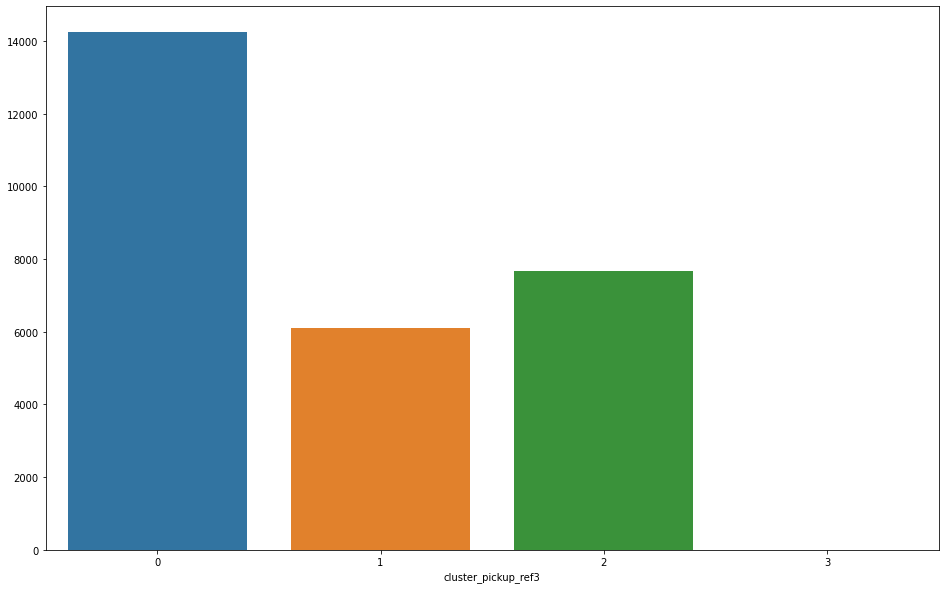

In [286]:
x = uio.groupby(['cluster_pickup_ref3'])['id'].count()
sns.barplot(x.index, x.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


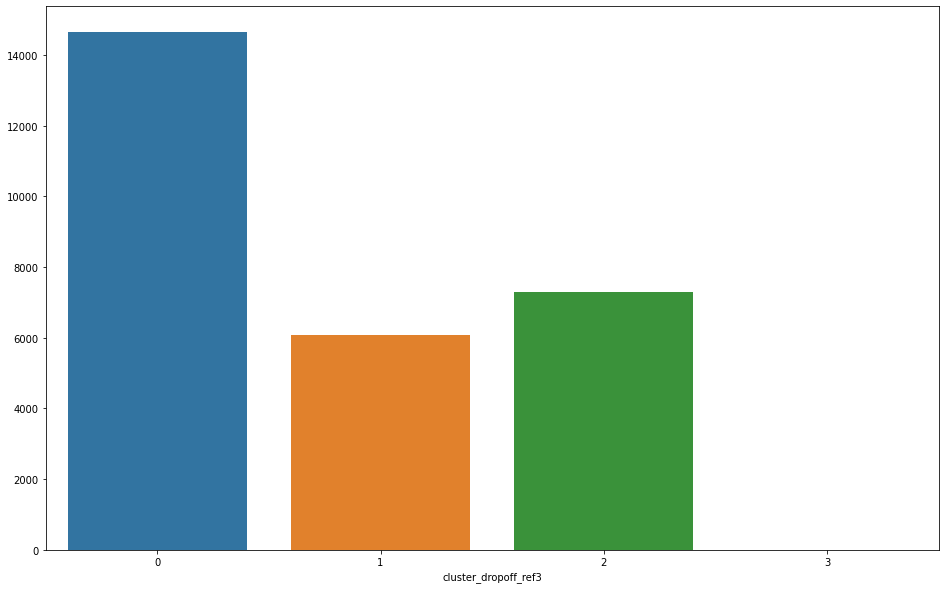

In [287]:
x = uio.groupby(['cluster_dropoff_ref3'])['id'].count()
sns.barplot(x.index, x.values)
plt.show()

In [288]:
uio = uio.drop(columns = ['id'], axis=1)

In [289]:
uio.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,ride_year,...,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,bearing,cluster_pickup_ref3,cluster_dropoff_ref3
0,-78.5039,-0.2328,-78.5494,-0.3614,33.750000,24.228,5.766667,5,9,2016,...,1,3,-0.0455,-0.1285,0,3.576550,43.072000,-160.516053,1,1
1,-78.4403,0.0068,-78.4908,-0.1048,23.166667,16.680,7.600000,4,9,2016,...,1,1,-0.0505,-0.1116,0,3.225520,43.200000,-155.652847,2,2
3,-78.5581,-0.2782,-78.4302,-0.2019,32.216667,25.146,5.033333,6,9,2016,...,1,4,0.1279,0.0763,0,3.532713,46.831661,59.181455,1,0
4,-78.5218,-0.2085,-78.5046,-0.2225,15.800000,4.625,5.233333,1,9,2016,...,1,4,0.0173,-0.0140,0,2.879198,17.563291,129.144217,0,0
5,-78.5092,-0.1948,-78.5188,-0.2288,25.166667,5.820,10.500000,2,8,2016,...,1,2,-0.0096,-0.0340,0,3.301991,13.875497,-164.232937,0,1


In [290]:
#uio = uio.drop(columns = ['trip_duration_log'], axis=1)

# **Split Data** Ref 4

In [294]:
train_dataset = uio.sample(frac=0.8, random_state=0)
test_dataset = uio.drop(train_dataset.index)

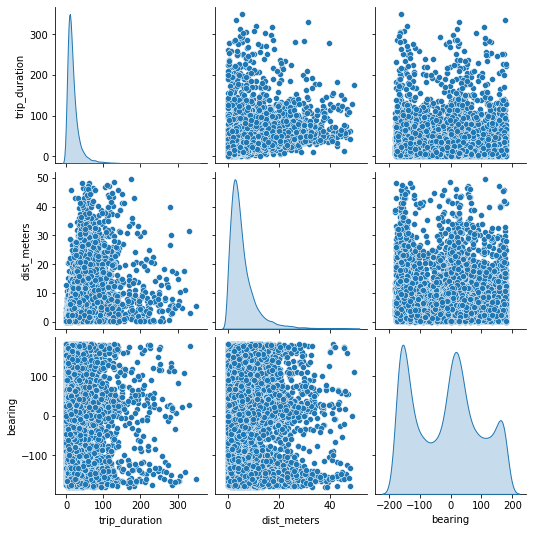

In [295]:
sns.pairplot(train_dataset[['trip_duration', 'dist_meters', 'bearing']], diag_kind='kde')

In [296]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pickup_longitude,22418.0,-78.491660,0.034024,-79.933200,-78.505500,-78.489800,-78.475400,-78.133000
pickup_latitude,22418.0,-0.188090,0.066154,-2.875800,-0.216600,-0.181900,-0.149800,0.866400
dropoff_longitude,22418.0,-78.492043,0.034436,-79.933100,-78.504800,-78.489700,-78.477225,-78.133200
dropoff_latitude,22418.0,-0.189722,0.067629,-2.875500,-0.218500,-0.185500,-0.151200,0.866800
trip_duration,22418.0,20.754557,25.668036,0.500000,8.166667,13.950000,23.683333,349.683333
dist_meters,22418.0,5.654178,5.586379,0.020000,2.239250,4.091000,7.103500,49.581000
wait_sec,22418.0,6.452047,9.082914,0.000000,1.800000,3.866667,7.500000,99.933333
ride_length_grp,22418.0,1.660987,1.111797,1.000000,1.000000,1.000000,2.000000,10.000000
ride_month,22418.0,6.534347,3.374725,1.000000,4.000000,7.000000,9.000000,12.000000
ride_year,22418.0,2016.548934,0.497611,2016.000000,2016.000000,2017.000000,2017.000000,2017.000000


In [297]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('trip_duration')
test_labels = test_features.pop('trip_duration')

In [298]:
#train_features.pop('trip_duration_log')

#train_features.describe().transpose()[['mean', 'std']]

In [299]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
pickup_longitude,-78.491660,0.034024
pickup_latitude,-0.188090,0.066154
dropoff_longitude,-78.492043,0.034436
dropoff_latitude,-0.189722,0.067629
trip_duration,20.754557,25.668036
dist_meters,5.654178,5.586379
wait_sec,6.452047,9.082914
ride_length_grp,1.660987,1.111797
ride_month,6.534347,3.374725
ride_year,2016.548934,0.497611


In [300]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [301]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[-7.8491592e+01 -1.8809007e-01 -7.8492012e+01 -1.8972142e-01
   5.6541772e+00  6.4520411e+00  1.6609840e+00  6.5343437e+00
   2.0165483e+03  1.5879379e+01  6.9583378e+00  2.9139713e+01
   2.7126415e+00  3.8785788e-01  9.8608214e-01  2.4315283e+00
  -3.8360717e-04 -1.6320314e-03  2.1723617e-02  2.7981892e+00
   1.9349911e+01 -1.5027094e+01  7.6661658e-01  7.3936141e-01]]


In [302]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ -78.5    -0.16  -78.49   -0.21    8.38    9.27    2.      5.   2017.
    16.      9.     34.      1.      0.      1.      3.      0.     -0.05
     0.      3.25   21.24  178.34    0.      0.  ]]

Normalized: [[-0.14  0.38 -0.08 -0.31  0.49  0.31  0.3  -0.45  0.91  0.01  0.69  0.28
  -0.92 -0.8   0.12  0.51  0.09 -1.25 -0.15  0.58  0.15  1.79 -0.9  -0.87]]


# **Check Correlation**

# **Regression** Ref 4.1

In [303]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])

linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(24, 1) dtype=float32, numpy=
array([[-0.24523233],
       [-0.13460097],
       [-0.28813595],
       [ 0.29197624],
       [-0.01248869],
       [ 0.43113557],
       [ 0.40740684],
       [ 0.02754596],
       [-0.4715176 ],
       [-0.00673577],
       [ 0.17740145],
       [-0.36751187],
       [ 0.25665507],
       [-0.12875497],
       [-0.02524939],
       [-0.1339775 ],
       [-0.37452015],
       [-0.01939255],
       [ 0.14513841],
       [-0.43716052],
       [-0.20966509],
       [-0.26090232],
       [ 0.00143865],
       [-0.3013495 ]], dtype=float32)>

In [304]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [305]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 1min 24s, sys: 6.53 s, total: 1min 30s
Wall time: 1min 22s


In [306]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [trip_duration]')
  plt.legend()
  plt.grid(True)

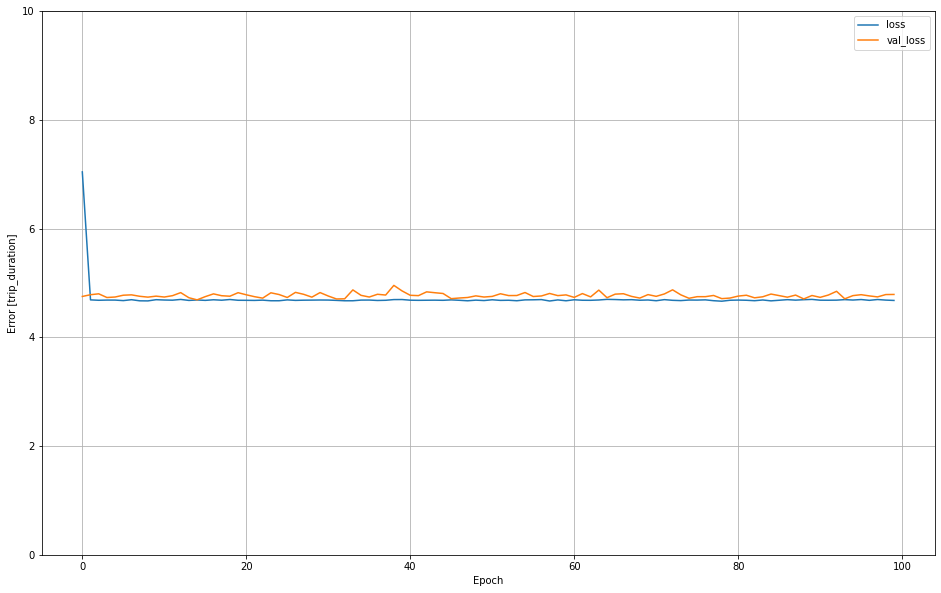

In [307]:
plot_loss(history)

In [308]:
test_results = {}

In [309]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# **Regression** Ref 4.2

In [310]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [311]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 24)               49        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                1600      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,874
Trainable params: 5,825
Non-trainable params: 49
_________________________________________________________________


In [319]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    #verbose=0, 
    epochs=100)

Epoch 1/100
561/561 [==============================] - 2s 3ms/step - loss: 0.1714 - val_loss: 0.1589
Epoch 2/100
561/561 [==============================] - 2s 3ms/step - loss: 0.1590 - val_loss: 0.1490
Epoch 3/100
561/561 [==============================] - 2s 3ms/step - loss: 0.1570 - val_loss: 0.1536
Epoch 4/100
561/561 [==============================] - 2s 4ms/step - loss: 0.1560 - val_loss: 0.1700
Epoch 5/100
561/561 [==============================] - 1s 2ms/step - loss: 0.1631 - val_loss: 0.1343
Epoch 6/100
561/561 [==============================] - 1s 2ms/step - loss: 0.1550 - val_loss: 0.2401
Epoch 7/100
561/561 [==============================] - 1s 2ms/step - loss: 0.1597 - val_loss: 0.1679
Epoch 8/100
561/561 [==============================] - 1s 2ms/step - loss: 0.1531 - val_loss: 0.1851
Epoch 9/100
561/561 [==============================] - 1s 2ms/step - loss: 0.1708 - val_loss: 0.1641
Epoch 10/100
561/561 [==============================] - 1s 2ms/step - loss: 0.1571 - val_lo

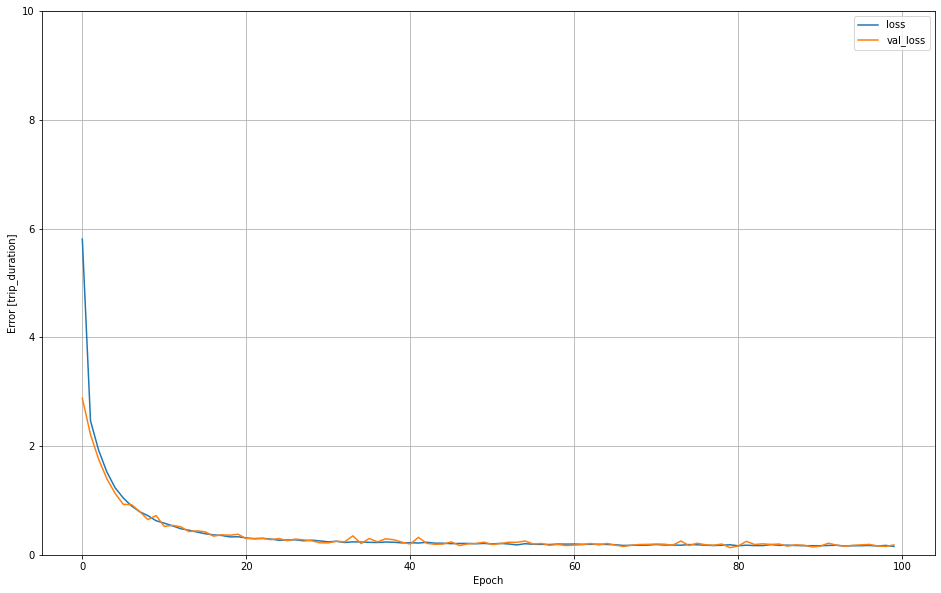

In [313]:
plot_loss(history)

In [314]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [315]:
pd.DataFrame(test_results, index=['Mean absolute error [trip_duration]']).T

,Mean absolute error [trip_duration]
linear_model,4.717116
dnn_model,0.190453


In [316]:
pd.DataFrame(test_results, index=['Mean absolute error [trip_duration]']).T

,Mean absolute error [trip_duration]
linear_model,4.717116
dnn_model,0.190453


# **Make Predition** Ref 4

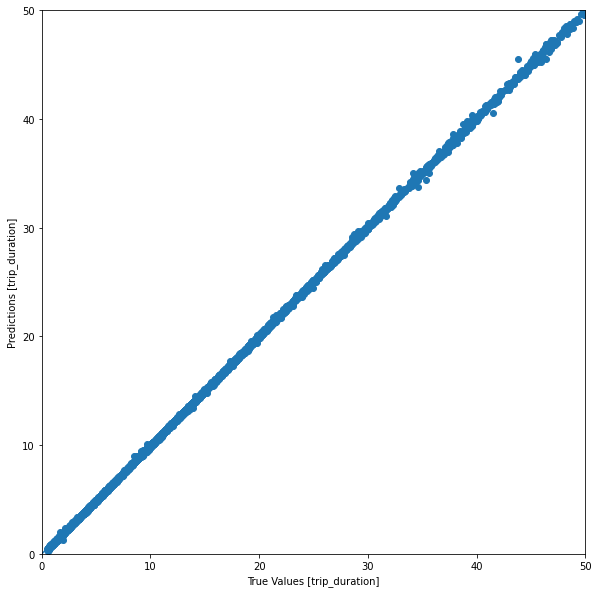

In [317]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [trip_duration]')
plt.ylabel('Predictions [trip_duration]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

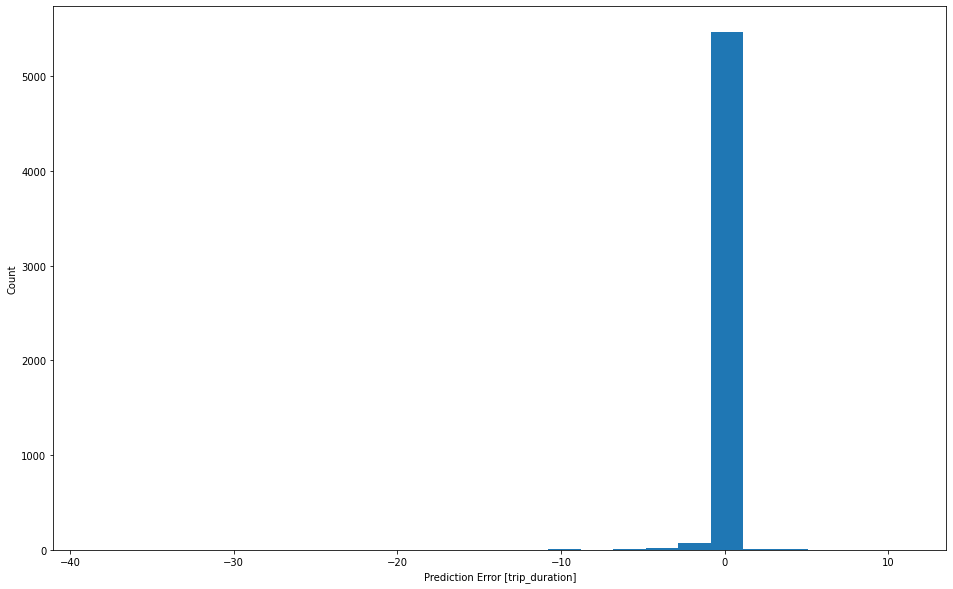

In [318]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [trip_duration]')
_ = plt.ylabel('Count')

# **Prediction** Ref 1

In [87]:
d_Tr = xgb.DMatrix(X_Tr, label=Y_Tr)
d_Te = xgb.DMatrix(X_Te)

In [88]:
def xgb_evaluate(max_depth, gamma,min_child_weight,max_delta_step,subsample,colsample_bytree, eta):
    params = {'eval_metric': 'rmse',
                  'max_depth': int(max_depth),
                  'subsample': subsample,
                  'eta': eta,
                  'gamma': gamma,
                  'colsample_bytree': colsample_bytree,   
                  'min_child_weight': min_child_weight ,
                  'max_delta_step':max_delta_step
                 }
    # Use cross validation to avoid over fitting
    cv_result = xgb.cv(params, d_Tr, num_boost_round=1000, nfold=3, metrics = "rmse", early_stopping_rounds=10, seed=3113)    
    print("Number of Trees", cv_result.shape[0])
        
    # Returning negative of RMSE since Bayesian optimization only knows how to maximize
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [89]:
%%time
xgb_bo = BayesianOptimization(xgb_evaluate, {
    'eta': (0.01, 0.1),
    'max_depth': (2, 6),
    'gamma': (0, 5),
    'min_child_weight': (1, 20),
    'max_delta_step': (0, 10),
    'subsample': (0.2, 1),
    'colsample_bytree' :(0.2, 0.8)})

# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=5, n_iter=50, acq='ei')

|   iter    |  target   | colsam... |    eta    |   gamma   | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------
Number of Trees 331
|  1        | -0.4623   |  0.4314   |  0.07419  |  2.981    |  0.4399   |  2.786    |  10.91    |  0.2837   |
Number of Trees 121
|  2        | -0.4548   |  0.5737   |  0.07707  |  1.029    |  9.796    |  5.027    |  9.769    |  0.7919   |
Number of Trees 212
|  3        | -0.4578   |  0.3266   |  0.06098  |  3.657    |  0.6567   |  5.103    |  7.819    |  0.4112   |
Number of Trees 151
|  4        | -0.4562   |  0.726    |  0.08276  |  2.892    |  2.925    |  4.313    |  7.758    |  0.686    |
Number of Trees 170
|  5        | -0.4562   |  0.4521   |  0.09537  |  3.979    |  2.989    |  4.672    |  15.78    |  0.7434   |
Number of Trees 299
|  6        | -0.4572   |  0.213    |  0.0768   |  4.313    |  8.675    |  5.708    |  1.447    |  0.7077   |


KeyboardInterrupt: ignored

In [ ]:
params = xgb_bo.max['params']
print(params)

In [ ]:
params['max_depth'] = int(params['max_depth'])

In [ ]:
# Train a new model with the best parameters from the search
model2 = xgb.train(params, d_Tr, num_boost_round=650)

# Predict on testing and training set
y_pred_xgb = model2.predict(d_Te)
y_train_pred_xgb = model2.predict(d_Tr)

In [ ]:
# Report testing and training RMSE
print('Test error:', np.sqrt(mean_squared_error(Y_Te, y_pred_xgb)))
print('Train error:', np.sqrt(mean_squared_error(Y_Tr, y_train_pred_xgb)))


In [ ]:
sns.distplot(y_pred_xgb, label='y_hat')
sns.distplot(Y_Te, label='y')
plt.legend()
sns.despine()
plt.tight_layout();

In [ ]:

wait_sec_train = (np.expm1(Y_Tr)*60).round()
np.quantile(wait_sec_train, [0, 0.05, 0.5, 0.95, 0.99])

In [ ]:
wait_sec_true = (np.expm1(Y_Te)*60).round()
wait_sec_predicted = (np.expm1(y_pred_xgb)*60).round()


In [ ]:
wait_sec_predicted

In [ ]:
wait_sec_true = np.array(wait_sec_true).T[0]
residual = wait_sec_predicted - wait_sec_true.T
wait_sec_true

In [ ]:
residual

In [ ]:
fig = plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
ax1 = sns.distplot(residual)
ax1.set_title('Distribution of residuals\n')
ax1.set_xlabel('')

plt.subplot(1, 2, 2)
ax2 = sns.boxplot(residual, showfliers=False)
ax2.set_xlabel('')

sns.despine()
plt.tight_layout()

In [ ]:
print("Mean absolute error:", np.abs(residual).mean())

In [ ]:
# feature importance
fig =  plt.figure(figsize = (12,8))
axes = fig.add_subplot(111)
xgb.plot_importance(model2,ax = axes,height =0.5)
sns.despine()
plt.tight_layout()

In [ ]:
featuresImp = model2.get_score(importance_type='gain')
print(featuresImp)

Elastic Net Model

In [ ]:
grid_search = GridSearchCV( 
                              estimator= ElasticNet(),
                              param_grid={
                              'alpha':[0.001,0.003, 0.01, 0.03,0.05,0.08, 0.1, 0.12, 0.15, 0.17, 0.2, 0.21, 0.22, 0.23, 02.24, 0.25],
                              'l1_ratio': [0.1, 0.25, 0.2, 0.25, 0.3,0.35,0.4,0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.80, 0.85, 0.90]
                          },
          scoring="neg_mean_squared_error",  
          cv=KFold(n_splits=3,shuffle=True,random_state=42))   
        
grid_search.fit(X_Tr, Y_Tr)
CVed_model = grid_search.best_estimator_
print(grid_search.best_params_)

In [ ]:
y_tr_pred_EN = CVed_model.predict(X_Tr)
rmse = np.sqrt(((y_tr_pred_EN - Y_Tr.values.ravel())**2).mean())
print("The train error is: ",rmse)

y_pred_EN = CVed_model.predict(X_Te)
rmse = np.sqrt(((y_pred_EN - Y_Te.values.ravel())**2).mean())
print("The train error is: ",rmse)

# The performance of the Elastic Net is slightly worse than xgboost while using RMSE as comparison

In [ ]:
y_tr_pred_EN = CVed_model.predict(X_Tr)
mae = np.abs((y_tr_pred_EN - Y_Tr.values.ravel()))
print("The train error is: ",mae.mean())

y_pred_EN = CVed_model.predict(X_Te)
mae = np.abs((Y_Te.values.ravel() - y_pred_EN))
print("The test error is: ",mae.mean())

In [ ]:
y_pred = y_pred_xgb*0.75 + 0.25*y_pred_EN
rmse = np.sqrt(((y_pred - Y_Te.values.ravel())**2).mean())
print("The test error is: ",rmse)

In [ ]:
sns.distplot(y_pred, label='y_hat')
sns.distplot(Y_Te, label='y')
plt.legend()
sns.despine()
plt.tight_layout();